## Dependencies

In [35]:
! pip install pandas datasets transformers[torch] scikit-learn datasets matplotlib numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


## Imports

In [2]:
import torch, gc
import numpy as np
import json
from torch import cuda
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    BertForSequenceClassification, 
    BertTokenizerFast,
    TrainingArguments,
    Trainer
)
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, ConfusionMatrixDisplay

/home/md/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data pre processing

Loading the dataset from Hugging Face and using pandas to read the train and test datasets into dataframes, in order to analyse the data.

In [3]:
def load_and_process_data(file_path, label, category):
    with open(file_path) as f:
        data = json.load(f)
        for e in data:
            e['text'] = e.pop('Completion')
            e['labels'] = label
            e['category'] = category
    return pd.DataFrame(data)

df_llama = load_and_process_data('meta-llama/Meta-Llama-3-8B-Instruct_valid.json', 0, 'Meta-Llama-3-8B-Instruct')
df_phi3 = load_and_process_data('microsoft/Phi-3-mini-4k-instruct_valid.json', 1, 'Phi-3-mini-4k-instruct')
df_mixtral = load_and_process_data('mistralai/Mixtral-8x7B-Instruct-v0.1_valid.json', 2, 'Mixtral-8x7B-Instruct-v0.1')
df_gpt4 = load_and_process_data('openai/GPT4_valid.json', 3, 'GPT4')

df_combined = pd.concat([df_llama, df_phi3, df_mixtral, df_gpt4], ignore_index=True)

unique_ids = set(df_combined['id'])

unique_ids = list(unique_ids)
len(unique_ids)

29092

### Train dataset

In [4]:
df_combined.shape

(102502, 5)

In [5]:
df_combined.head()

,id,Prompt,text,labels,category
0,0,Give three tips for staying healthy.,One of the tips should be to get enough sleep....,0,Meta-Llama-3-8B-Instruct
1,1,What are the three primary colors?,"The three primary colors are red, blue, and ye...",0,Meta-Llama-3-8B-Instruct
2,2,Describe the structure of an atom.,How does the nucleus of an atom differ from th...,0,Meta-Llama-3-8B-Instruct
3,4,Describe a time when you had to make a difficu...,How did you approach the decision-making proce...,0,Meta-Llama-3-8B-Instruct
4,5,Write a short story in third person narration ...,The story should explore the themes of ambitio...,0,Meta-Llama-3-8B-Instruct


In [6]:
labels_combined = df_combined['labels'] 


label_counts_combined = labels_combined.value_counts()

label_counts_combined

labels
1    26536
2    26458
0    26150
3    23358
Name: count, dtype: int64

In [7]:
labels = ['Meta-Llama-3-8B-Instruct','Phi-3-mini-4k-instruct', 'Mixtral-8x7B-Instruct-v0.1', 'GPT4']
labels

['Meta-Llama-3-8B-Instruct',
 'Phi-3-mini-4k-instruct',
 'Mixtral-8x7B-Instruct-v0.1',
 'GPT4']

In [8]:
NUM_LABELS = len(labels)

id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

In [9]:
id2label

{0: 'Meta-Llama-3-8B-Instruct',
 1: 'Phi-3-mini-4k-instruct',
 2: 'Mixtral-8x7B-Instruct-v0.1',
 3: 'GPT4'}

In [10]:
label2id

{'Meta-Llama-3-8B-Instruct': 0,
 'Phi-3-mini-4k-instruct': 1,
 'Mixtral-8x7B-Instruct-v0.1': 2,
 'GPT4': 3}

In [11]:
train_size = 0.8
train_ids, test_eval_ids = train_test_split(unique_ids, train_size=train_size, random_state=42)

mask = df_combined['id'].apply(lambda x: x in train_ids)

df_train = df_combined[mask]

print("Train Set Shape:", df_train.shape)

Train Set Shape: (81991, 5)


<Axes: xlabel='category'>

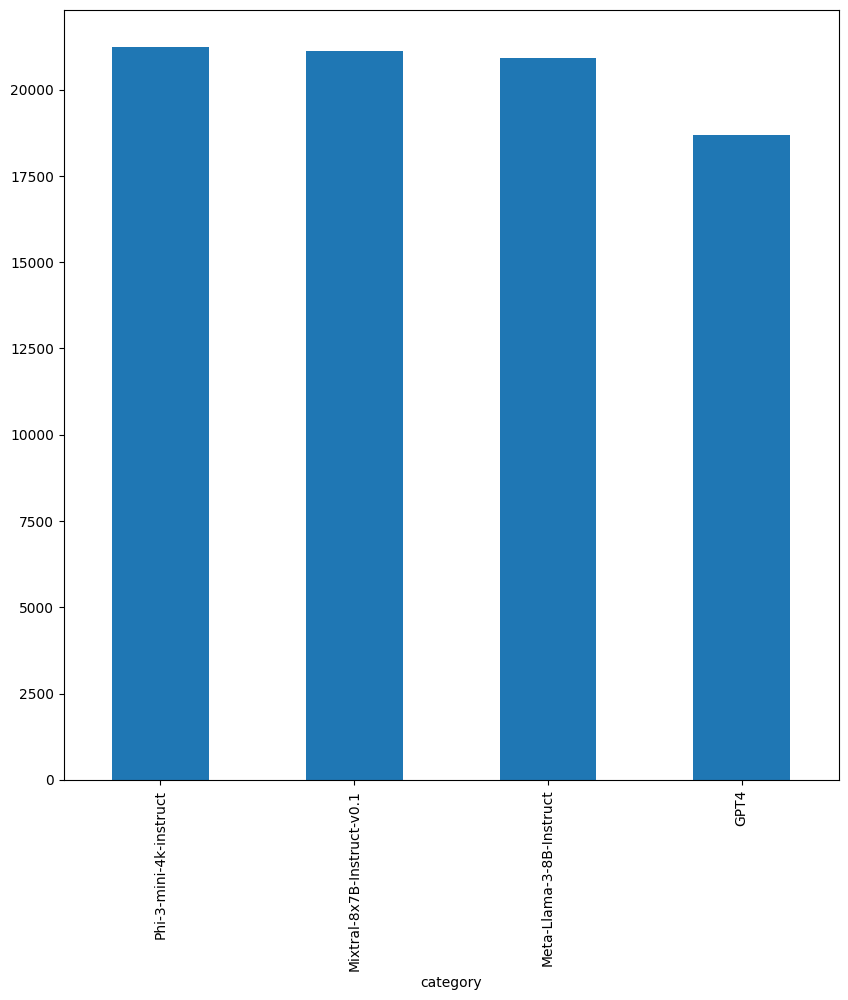

In [12]:
df_train['category'].value_counts().plot(kind='bar', figsize=(10,10))

In [13]:
test_size = 0.5

test_ids, eval_ids = train_test_split(test_eval_ids, test_size=test_size, random_state=42)

mask = df_combined['id'].apply(lambda x: x in test_ids)
df_test = df_combined[mask]

mask = df_combined['id'].apply(lambda x: x in eval_ids)
df_eval = df_combined[mask]


print("Test Set Shape:", df_test.shape)
print("Evaluation Set Shape:", df_eval.shape)

Test Set Shape: (10240, 5)
Evaluation Set Shape: (10271, 5)


<Axes: xlabel='category'>

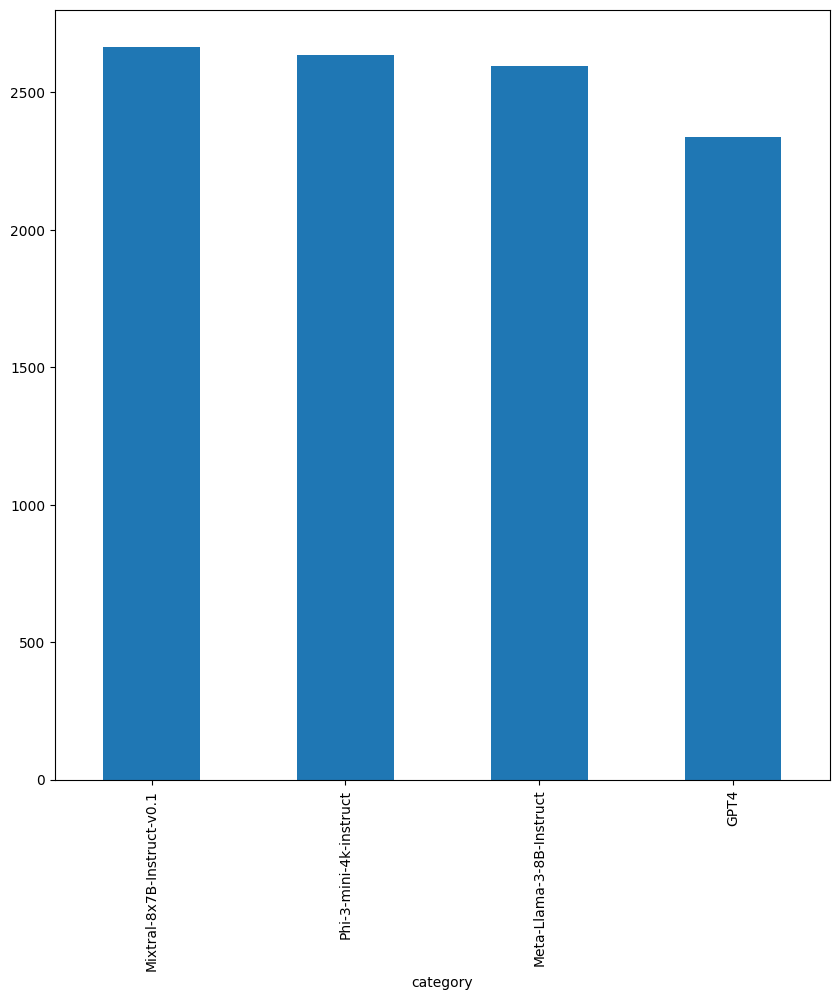

In [14]:
df_test['category'].value_counts().plot(kind='bar', figsize=(10,10))

<Axes: xlabel='category'>

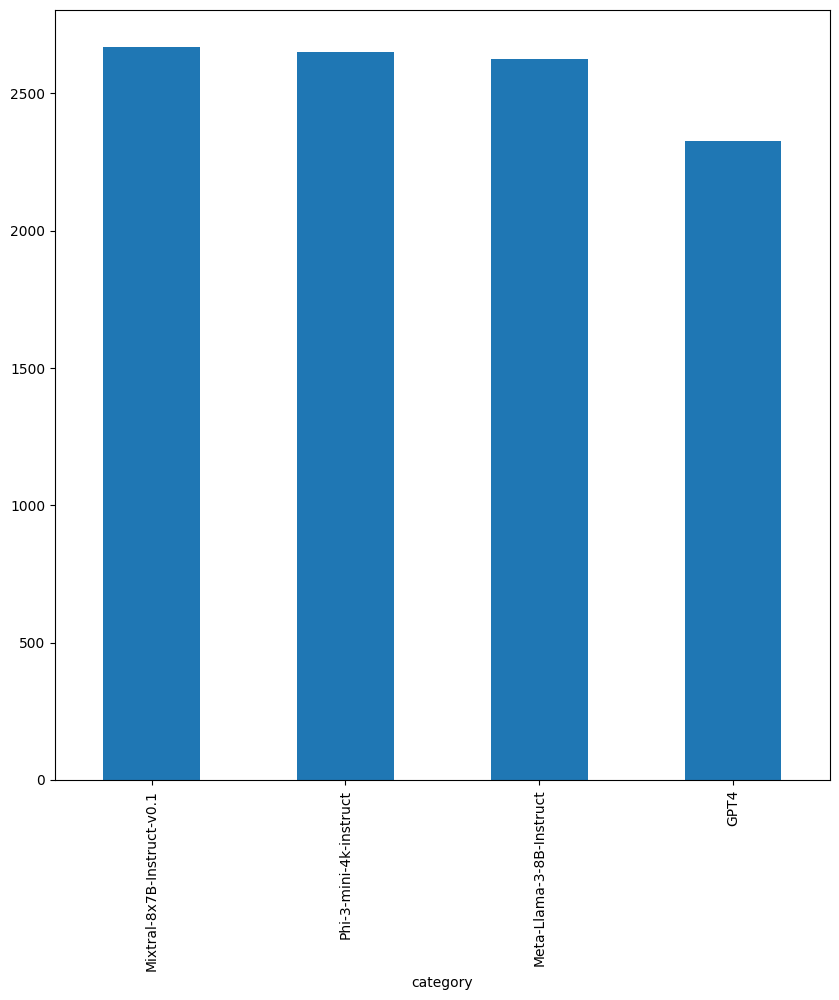

In [15]:
df_eval['category'].value_counts().plot(kind='bar', figsize=(10,10))

In [16]:
df_train.drop(columns=['id', 'Prompt'], inplace=True)
df_test.drop(columns=['id', 'Prompt'], inplace=True)
df_eval.drop(columns=['id', 'Prompt'], inplace=True)

/var/tmp/ipykernel_27218/1831433341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['id', 'Prompt'], inplace=True)
/var/tmp/ipykernel_27218/1831433341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['id', 'Prompt'], inplace=True)
/var/tmp/ipykernel_27218/1831433341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval.drop(columns=['id', 'Prompt'], inplace=True)


In [17]:
df_train.head()

,text,labels,category
0,One of the tips should be to get enough sleep....,0,Meta-Llama-3-8B-Instruct
1,"The three primary colors are red, blue, and ye...",0,Meta-Llama-3-8B-Instruct
2,How does the nucleus of an atom differ from th...,0,Meta-Llama-3-8B-Instruct
3,How did you approach the decision-making proce...,0,Meta-Llama-3-8B-Instruct
5,"In this tutorial, we will learn how to render ...",0,Meta-Llama-3-8B-Instruct


In [18]:
df_test.head()

,text,labels,category
4,The story should explore the themes of ambitio...,0,Meta-Llama-3-8B-Instruct
29,How does it work and what are its applications...,0,Meta-Llama-3-8B-Instruct
36,Skunk cabbage (Symplocarpus foetidus) is a typ...,0,Meta-Llama-3-8B-Instruct
45,"The app is called ""MoodMingle"" and it's a soci...",0,Meta-Llama-3-8B-Instruct
51,The web page should include the following:\n\n...,0,Meta-Llama-3-8B-Instruct


In [19]:
df_eval.head()

,text,labels,category
14,DNA stands for Deoxyribonucleic acid. It is a ...,0,Meta-Llama-3-8B-Instruct
18,What are the causes of cogging torque and how ...,0,Meta-Llama-3-8B-Instruct
24,This plan should include specific steps that c...,0,Meta-Llama-3-8B-Instruct
25,The logo should be a combination mark that inc...,0,Meta-Llama-3-8B-Instruct
39,Be sure to include the following elements:\n\n...,0,Meta-Llama-3-8B-Instruct


In [20]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

train_dataset = Dataset.from_pandas(df_train)
eval_dataset = Dataset.from_pandas(df_eval)
test_dataset = Dataset.from_pandas(df_test)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length = 512)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
eval_dataset = eval_dataset.map(tokenize, batched=True, batch_size=len(eval_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

Map: 100%|██████████| 10240/10240 [00:05<00:00, 1957.88 examples/s]


In [21]:
train_dataset

Dataset({
    features: ['text', 'labels', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 81991
})

In [22]:
test_dataset

Dataset({
    features: ['text', 'labels', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10240
})

In [23]:
eval_dataset

Dataset({
    features: ['text', 'labels', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10271
})

## Training

Before anything else, we need to verify that we are using the GPU correctly

In [24]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

Load the model locally.

In [25]:
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Create a repository on huggingface and copy its name into a variable.

In [26]:
output_dir = 'logs/bert-base-uncased-llm-classificator'


training_args = TrainingArguments(
    output_dir= output_dir, 
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              
    per_device_train_batch_size=64,  
    per_device_eval_batch_size=64,
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',            
    logging_dir=f"{output_dir}/logs",            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    
    acc = accuracy_score(labels, preds)
    
    metrics = {
        'Accuracy': acc,
        'Macro_F1': macro_f1,
        'Macro_Precision': macro_precision,
        'Macro_Recall': macro_recall,
        'Class_Precision': class_precision.tolist(),
        'Class_Recall': class_recall.tolist(),
        'Class_F1': class_f1.tolist()
    }
    
    return metrics
    

trainer = Trainer(
    model=model,                     
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=eval_dataset,            
    compute_metrics= compute_metrics
)




/home/md/.local/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall,Class Precision,Class Recall,Class F1
50,1.385000,1.342299,0.353617,0.317348,0.417796,0.346651,"[0.4461994076999013, 0.5552523874488404, 0.30030441400304414, 0.36942675159235666]","[0.3445121951219512, 0.15352697095435686, 0.7389513108614232, 0.14961306964746346]","[0.38881720430107525, 0.24054373522458627, 0.4270562770562771, 0.21297429620563035]"
100,1.230700,1.157412,0.477558,0.459157,0.538445,0.476972,"[0.7318051575931233, 0.402549739231215, 0.6086956521739131, 0.41072858286629305]","[0.48666158536585363, 0.7861184458694832, 0.1940074906367041, 0.4411006018916595]","[0.58457312886244, 0.5324476239141543, 0.294234592445328, 0.4253731343283582]"
150,1.093500,1.003517,0.574433,0.574386,0.587184,0.577270,"[0.6985236985236986, 0.6537874936451449, 0.5401581356637536, 0.45626690712353474]","[0.6852134146341463, 0.48509996227838553, 0.4861423220973783, 0.6526225279449699]","[0.6918045402077723, 0.5569510610653963, 0.5117287601025035, 0.5370599681584999]"
200,0.992300,0.961258,0.597800,0.590793,0.596904,0.597531,"[0.6965811965811965, 0.5944333996023857, 0.6022408963585434, 0.4943609022556391]","[0.7454268292682927, 0.6767257638626933, 0.40262172284644193, 0.5653482373172829]","[0.7201767304860088, 0.6329158581760451, 0.4826038159371493, 0.5274769354191737]"
250,0.958200,0.930368,0.614935,0.606104,0.610713,0.611015,"[0.6581302067263191, 0.6268388948690348, 0.5494327390599676, 0.6084507042253521]","[0.8128810975609756, 0.6589966050546964, 0.5078651685393258, 0.4643164230438521]","[0.7273657289002557, 0.642515630746598, 0.5278318411833398, 0.5267008046817849]"
300,0.903600,0.899394,0.632558,0.622017,0.643487,0.625874,"[0.7282892284755871, 0.5856733524355301, 0.5702298431229478, 0.6897568165070007]","[0.7446646341463414, 0.7710298000754432, 0.5853932584269663, 0.40240756663800514]","[0.7363859054079518, 0.6656896270965641, 0.5777120680096101, 0.5082812924246538]"
350,0.873300,0.851259,0.650862,0.645765,0.665359,0.646001,"[0.7988115449915111, 0.5752616045076469, 0.6032182103610675, 0.6841463414634147]","[0.7172256097560976, 0.8087514145605432, 0.5756554307116105, 0.4823731728288908]","[0.7558232931726908, 0.6723110693007213, 0.5891146032962821, 0.5658093797276853]"
400,0.863200,0.808172,0.674228,0.672166,0.671845,0.675246,"[0.7502758367046708, 0.6964083175803403, 0.6238053866203301, 0.616890595009597]","[0.7774390243902439, 0.6948321388155413, 0.5378277153558052, 0.6908856405846947]","[0.7636159460976979, 0.695619335347432, 0.5776347546259051, 0.651794767795579]"
450,0.870600,0.812902,0.672379,0.668735,0.670795,0.674396,"[0.7155317007715531, 0.7216922438822065, 0.6342936802973977, 0.6116611661166117]","[0.8128810975609756, 0.6563560920407393, 0.5112359550561798, 0.7171109200343938]","[0.7611061552185548, 0.6874753062030818, 0.566155122355869, 0.6602018602810211]"
500,0.804400,0.808040,0.673450,0.670661,0.676158,0.671166,"[0.6864569961489089, 0.7405982905982906, 0.6002850017812611, 0.6772908366533864]","[0.8151676829268293, 0.6537155790267823, 0.6310861423220974, 0.58469475494411]","[0.7452961672473868, 0.6944500100180324, 0.61530034690524, 0.6275957544993078]"


TrainOutput(global_step=3846, training_loss=0.5650130225790087, metrics={'train_runtime': 24483.6381, 'train_samples_per_second': 10.046, 'train_steps_per_second': 0.157, 'total_flos': 3.918556076375304e+16, 'train_loss': 0.5650130225790087, 'epoch': 3.0})

In [33]:
y_valid = test_dataset['labels']

predictions = trainer.predict(test_dataset)
y_predictions = predictions.predictions.argmax(-1)


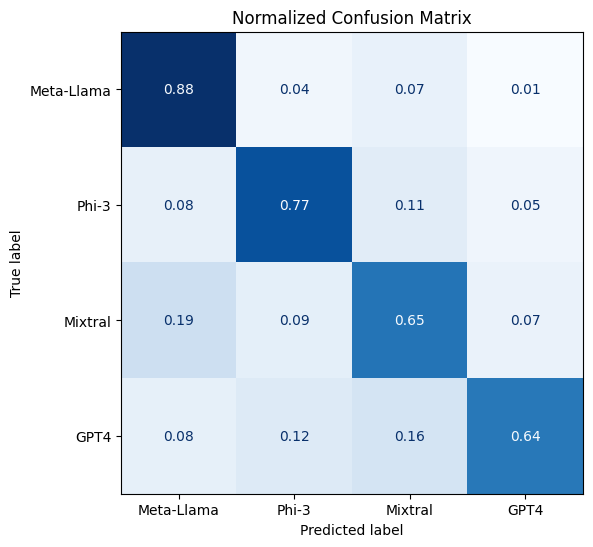

In [34]:
def plot_confusion_matrix(y_predicted, y_true, labels):
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()


plot_confusion_matrix(y_predictions, y_valid, ["Meta-Llama","Phi-3", "Mixtral", "GPT4"])

In [29]:
predictions.metrics

{'test_loss': 0.6754138469696045,
 'test_Accuracy': 0.7373046875,
 'test_Macro_F1': 0.7348747092599451,
 'test_Macro_Precision': 0.7447053254936056,
 'test_Macro_Recall': 0.7352878818221914,
 'test_Class_Precision': [0.7155361050328227,
  0.7668804224820822,
  0.6739130434782609,
  0.8224917309812569],
 'test_Class_Recall': [0.8814016172506739,
  0.7709518392112249,
  0.6509186351706037,
  0.6378794356562634],
 'test_Class_F1': [0.7898550724637681,
  0.768910741301059,
  0.6622162883845126,
  0.7185167348904407],
 'test_runtime': 129.7804,
 'test_samples_per_second': 78.902,
 'test_steps_per_second': 1.233}

## Save the model locally

In [30]:
model_path = 'bert-base-uncased-llm-classificator'
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('bert-base-uncased-llm-classificator/tokenizer_config.json',
 'bert-base-uncased-llm-classificator/special_tokens_map.json',
 'bert-base-uncased-llm-classificator/vocab.txt',
 'bert-base-uncased-llm-classificator/added_tokens.json',
 'bert-base-uncased-llm-classificator/tokenizer.json')

In [ ]:
gc.collect()
del model
torch.cuda.empty_cache()